In [45]:
!pip install tensorflow==2.4.1

In [46]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [47]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [48]:
!git clone https://github.com/valwork2021/Sunspot_Prediction.git

fatal: destination path 'Sunspot_Prediction' already exists and is not an empty directory.


In [49]:
import csv
building1 = []
building2 = []

with open('/content/Sunspot_Prediction/insights_product_by_hour.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  next(reader)
  for row in reader:
    building1.append(row[1])
    building2.append(row[2])

series = np.array(building2)
series[series == ''] = 0
series = series.astype(np.float64)

time = np.array(list(range(0, len(series))))
print('series: {}'.format(series[:5]))
print('time: {}'.format(time[:5]))

series: [1607. 1430.  696.  680.  491.]
time: [0 1 2 3 4]


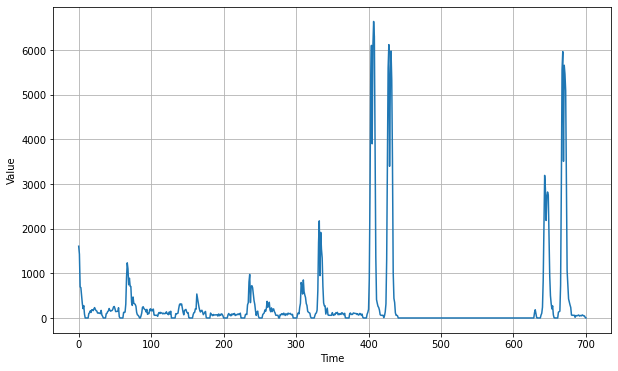

In [50]:
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [51]:
split_time = 350
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [52]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [53]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
shuffle_buffer_size = 1000
window_size = 60
batch_size = 100
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(x_train.shape)

(350,)


In [54]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 60)          360       
_________________________________________________________________
lstm (LSTM)                  (None, None, 60)          29040     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 60)          29040     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1830      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

In [55]:
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=500)

Epoch 1/500
3/3 [==============================] - 2s 15ms/step - loss: 155.5630 - mae: 156.0600
Epoch 2/500
3/3 [==============================] - 0s 15ms/step - loss: 120.1813 - mae: 120.6798
Epoch 3/500
3/3 [==============================] - 0s 14ms/step - loss: 114.1636 - mae: 114.6619
Epoch 4/500
3/3 [==============================] - 0s 15ms/step - loss: 107.0215 - mae: 107.5197
Epoch 5/500
3/3 [==============================] - 0s 14ms/step - loss: 101.3348 - mae: 101.8330
Epoch 6/500
3/3 [==============================] - 0s 14ms/step - loss: 95.0226 - mae: 95.5201
Epoch 7/500
3/3 [==============================] - 0s 14ms/step - loss: 92.5667 - mae: 93.0647
Epoch 8/500
3/3 [==============================] - 0s 15ms/step - loss: 87.5009 - mae: 87.9994
Epoch 9/500
3/3 [==============================] - 0s 14ms/step - loss: 88.6781 - mae: 89.1761
Epoch 10/500
3/3 [==============================] - 0s 15ms/step - loss: 83.5311 - mae: 84.0295
Epoch 11/500
3/3 [=====================

<Figure size 432x288 with 0 Axes>

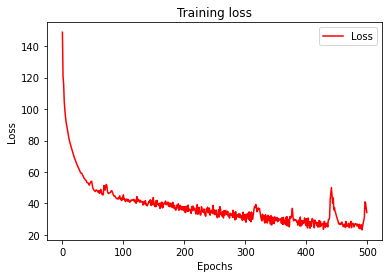

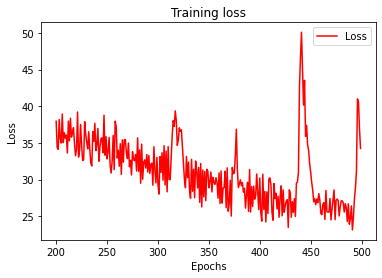

<Figure size 432x288 with 0 Axes>

In [56]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']
epochs=range(len(loss)) # Get number of epochs
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])
plt.figure()


zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [57]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [58]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

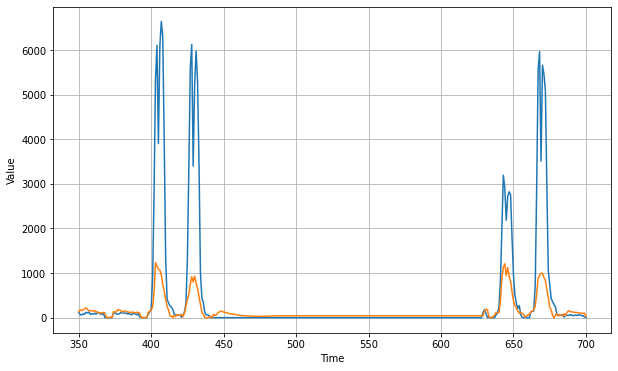

In [59]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [60]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

376.69952